In [621]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import zlib
import base64
import seaborn as sns
import matplotlib.pyplot as plt

In [622]:
wdir = '/workspace/Benchmarking/data_all'
os.chdir(wdir)

In [43]:
f_loom_path_scenic = "lymphoma_scenic.loom"
f_loom_path_scenic_pred = "lymphoma_scenic_pred.loom"
f_pyscenic_output = "lymphoma_pyscenic_output.loom"
f_tfs = 'tf_list.txt'
f_pyscenic_output_pred = "lymphoma_pyscenic_output_pred.loom"

In [ ]:
rna_data = sc.read_h5ad('/workspace/scButterfly/data/lymphoma/RNA_pp.h5ad')

In [5]:
row_attrs = {
    "Gene": np.array(rna_data.var_names) ,
}
col_attrs = {
    "CellID": np.array(rna_data.obs_names) ,
    "nGene": np.array( np.sum(rna_data.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(rna_data.X.transpose() , axis=0)).flatten() ,
    "cell_type": np.array(rna_data.obs['Cell Types']) ,
}
lp.create(f_loom_path_scenic, rna_data.X.transpose(), row_attrs, col_attrs)

In [6]:
f_tfs = "/workspace/Benchmarking/scenicplus/resources/allTFs_hg38.txt" 


In [7]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20


2025-05-09 16:35:20,292 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-09 16:35:20,887 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
20 partitions
computing dask graph
not shutting down client, client was created externally
finished

2025-05-09 16:39:25,604 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [8]:
f_motif_path = 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
f_db_names = 'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [9]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20



2025-05-09 16:44:47,955 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-05-09 16:44:48,090 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-09 16:44:48,822 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-05-09 16:44:48,870 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-05-09 16:44:50,367 - pyscenic.utils - INFO - Creating modules.

2025-05-09 16:45:08,608 - pyscenic.cli.pyscenic - IN

In [10]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2025-05-09 16:52:13,643 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-09 16:52:14,237 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-05-09 16:52:14,327 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-05-09 16:52:21,494 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [44]:
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [45]:
auc_mtx

,BHLHE40(+),CTCF(+),ELF4(+),ELK3(+),ETS1(+),GATA5(+),HIF3A(+),HNF4G(+),HOXA10(+),IRF5(+),JUN(+),LMX1A(+),OTX1(+),POU3F1(+),RORA(+),SALL2(+),STAT2(+),TFAP4(+),ZBTB11(+),ZNF276(+)
AAACAGCCAGAACCGA-1,0.079324,0.005455,0.031833,0.023682,0.056012,0.078571,0.000000,0.008333,0.042121,0.090256,0.045333,0.054167,0.033333,0.047536,0.066667,0.065455,0.093793,0.000000,0.107605,0.054792
AAACAGCCAGCCTAAC-1,0.044348,0.000000,0.021333,0.037612,0.046589,0.000000,0.000000,0.000000,0.106667,0.005385,0.000000,0.061667,0.000000,0.000000,0.013714,0.000000,0.022414,0.000000,0.050716,0.155417
AAACAGCCATATTGAC-1,0.025990,0.089091,0.052500,0.079602,0.057166,0.064762,0.000000,0.000000,0.047879,0.034872,0.040889,0.000000,0.000000,0.021159,0.085333,0.000000,0.057471,0.000000,0.092148,0.070000
AAACATGCAAATTCGT-1,0.055169,0.200000,0.027167,0.031343,0.056279,0.029524,0.000000,0.000000,0.016667,0.015897,0.057778,0.049583,0.113333,0.000000,0.034476,0.090303,0.014598,0.000000,0.063457,0.010625
AAACATGCAACCTAAT-1,0.060580,0.000000,0.133167,0.073831,0.061990,0.280000,0.000000,0.002222,0.054242,0.070769,0.015556,0.005417,0.140000,0.003188,0.098095,0.000000,0.163793,0.000000,0.090815,0.025833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTATGGTGC-1,0.076812,0.000000,0.000000,0.055224,0.045177,0.000000,0.000000,0.000000,0.103939,0.002564,0.000000,0.041667,0.000000,0.000000,0.068762,0.000000,0.005632,0.000000,0.029975,0.015625
TTTGTTGGTCAATACG-1,0.058937,0.030303,0.044000,0.013930,0.055581,0.007619,0.054286,0.047778,0.041515,0.000000,0.081778,0.000000,0.033333,0.031594,0.048571,0.058182,0.054253,0.000000,0.050914,0.030833
TTTGTTGGTCAGGAAG-1,0.037101,0.000000,0.021000,0.042985,0.038226,0.060000,0.000000,0.000000,0.044545,0.009744,0.000000,0.000000,0.000000,0.000000,0.039619,0.000000,0.033103,0.000000,0.041284,0.081667
TTTGTTGGTTCAAGAT-1,0.047343,0.073333,0.021833,0.050746,0.041990,0.000000,0.000000,0.000000,0.072727,0.007949,0.000000,0.000000,0.000000,0.064928,0.028000,0.000000,0.007931,0.000000,0.029531,0.083750


In [8]:
rna_data_pred = sc.read_h5ad('/workspace/scButterfly/data/lymphoma/predicted/pred_RNA_lymphoma.h5ad')

In [10]:
rna_data_pred.var_names = rna_data.var_names

In [22]:
row_attrs = {
    "Gene": np.array(rna_data_pred.var_names) ,
}
col_attrs = {
    "CellID": np.array(rna_data_pred.obs_names) ,
    "nGene": np.array( np.sum(rna_data_pred.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(rna_data_pred.X.transpose() , axis=0)).flatten() ,
    "cell_type": np.array(rna_data_pred.obs['Cell Types']) ,
}
lp.create(f_loom_path_scenic_pred, rna_data_pred.X.transpose(), row_attrs, col_attrs)

In [23]:
!pyscenic aucell \
    {f_loom_path_scenic_pred} \
    reg.csv \
    --output {f_pyscenic_output_pred} \
    --num_workers 20


2025-05-12 09:44:37,364 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-12 09:44:37,582 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-05-12 09:44:37,675 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-05-12 09:44:43,420 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [14]:
lf = lp.connect(f_pyscenic_output_pred, mode='r+', validate=False )
auc_mtx_pred = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [15]:
auc_mtx_pred

,BHLHE40(+),CTCF(+),ELF4(+),ELK3(+),ETS1(+),GATA5(+),HIF3A(+),HNF4G(+),HOXA10(+),IRF5(+),JUN(+),LMX1A(+),OTX1(+),POU3F1(+),RORA(+),SALL2(+),STAT2(+),TFAP4(+),ZBTB11(+),ZNF276(+)
GTTCCCAGTTAGCATG-1,0.063092,0.015758,0.004000,0.018905,0.060327,0.000000,0.0,0.000000,0.000000,0.017179,0.000000,0.007500,0.000000,0.014493,0.019048,0.000000,0.016897,0.0,0.038568,0.082083
CCTGTATGTTTATGGG-1,0.072850,0.090909,0.016333,0.017313,0.055745,0.000000,0.0,0.002778,0.000000,0.029487,0.012000,0.039583,0.000000,0.011304,0.029333,0.000000,0.029080,0.0,0.059210,0.101250
AGAAACCCAATCTCTC-1,0.068406,0.193333,0.017667,0.029254,0.057623,0.000000,0.0,0.000000,0.000000,0.003077,0.000000,0.045000,0.081905,0.007826,0.026857,0.032121,0.019310,0.0,0.061531,0.065833
CAAATCATCACACAGT-1,0.084251,0.132121,0.020500,0.029552,0.060362,0.000000,0.0,0.000000,0.000000,0.020000,0.010667,0.032083,0.000000,0.027826,0.056381,0.000000,0.033563,0.0,0.067062,0.079583
GTGAGGAGTCTTACTA-1,0.122802,0.012727,0.098833,0.045871,0.058277,0.327143,0.0,0.047222,0.101818,0.166154,0.009333,0.020417,0.138095,0.029275,0.059238,0.000000,0.200460,0.0,0.067210,0.043750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAACCAGGTCAAAGGG-1,0.077585,0.030303,0.025000,0.041791,0.060844,0.000000,0.0,0.034444,0.000000,0.034359,0.030222,0.049167,0.000000,0.007246,0.029143,0.000000,0.022414,0.0,0.059210,0.146875
TGTTGTGCAGGCCAAA-1,0.081063,0.126667,0.020500,0.026070,0.058493,0.000000,0.0,0.000000,0.000000,0.025385,0.009333,0.024583,0.000000,0.027536,0.054286,0.000000,0.028621,0.0,0.062617,0.077708
GAAGGCCCATGTCAAT-1,0.080676,0.169697,0.013167,0.009652,0.056434,0.023333,0.0,0.000000,0.043333,0.071282,0.000000,0.082917,0.000000,0.008986,0.057905,0.000000,0.095402,0.0,0.105086,0.066458
ATGATGGAGCACTAGT-1,0.089565,0.013333,0.063500,0.029751,0.059630,0.207619,0.0,0.017222,0.057273,0.076154,0.000000,0.027917,0.135238,0.000000,0.042476,0.000000,0.093448,0.0,0.065086,0.042292


In [16]:
auc_mtx_true = auc_mtx.loc[list(auc_mtx_pred.index),:]

In [17]:
auc_mtx_true

,BHLHE40(+),CTCF(+),ELF4(+),ELK3(+),ETS1(+),GATA5(+),HIF3A(+),HNF4G(+),HOXA10(+),IRF5(+),JUN(+),LMX1A(+),OTX1(+),POU3F1(+),RORA(+),SALL2(+),STAT2(+),TFAP4(+),ZBTB11(+),ZNF276(+)
GTTCCCAGTTAGCATG-1,0.040097,0.084242,0.000000,0.036020,0.034332,0.069048,0.000000,0.000000,0.046667,0.047436,0.000000,0.000000,0.000000,0.035942,0.017524,0.000000,0.025172,0.000000,0.037827,0.059167
CCTGTATGTTTATGGG-1,0.024348,0.000000,0.039667,0.060995,0.035504,0.064762,0.000000,0.000000,0.086061,0.008205,0.051556,0.052917,0.000000,0.039420,0.016000,0.000000,0.042069,0.000000,0.035111,0.055833
AGAAACCCAATCTCTC-1,0.050725,0.136970,0.038833,0.049055,0.061860,0.091429,0.000000,0.056667,0.073333,0.017949,0.000000,0.057500,0.000000,0.020580,0.077714,0.164242,0.108736,0.000000,0.125037,0.039792
CAAATCATCACACAGT-1,0.025217,0.104242,0.000000,0.030249,0.050172,0.000000,0.000000,0.000000,0.019697,0.000000,0.052889,0.053750,0.092381,0.044928,0.031429,0.000000,0.046667,0.121111,0.033630,0.083958
GTGAGGAGTCTTACTA-1,0.062319,0.045455,0.065167,0.048458,0.058191,0.194762,0.000000,0.061111,0.126061,0.087179,0.052444,0.030417,0.138095,0.028116,0.048190,0.000000,0.128621,0.000000,0.067506,0.027500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAACCAGGTCAAAGGG-1,0.066280,0.000000,0.000000,0.040000,0.034892,0.062857,0.000000,0.000000,0.051515,0.012308,0.000000,0.053333,0.000000,0.000000,0.069333,0.000000,0.027931,0.004444,0.047556,0.062500
TGTTGTGCAGGCCAAA-1,0.060386,0.000000,0.020833,0.054527,0.043144,0.058571,0.000000,0.000000,0.056061,0.024615,0.000000,0.000000,0.117143,0.029855,0.049714,0.161212,0.036322,0.000000,0.038123,0.069375
GAAGGCCCATGTCAAT-1,0.097488,0.000000,0.001333,0.012637,0.044427,0.014286,0.000000,0.000000,0.042727,0.041282,0.030222,0.065833,0.059048,0.000000,0.049143,0.000000,0.065862,0.116667,0.054074,0.050625
ATGATGGAGCACTAGT-1,0.107923,0.073939,0.113667,0.055920,0.053290,0.188095,0.000000,0.038889,0.107879,0.097179,0.029778,0.000000,0.130476,0.000290,0.043238,0.004848,0.105172,0.000000,0.084346,0.042917


In [89]:
print(sum(auc_mtx_true['HIF3A(+)']))
print(sum(auc_mtx['HIF3A(+)']))
print(sum(auc_mtx_pred['HIF3A(+)']))

15.196190476190488
73.92952380952383
0.0


In [90]:
grcs = 0
for i in auc_mtx_true.columns:
    grcs += np.sqrt(np.mean((auc_mtx_true[i] - auc_mtx_pred[i])**2))
print((grcs/len(auc_mtx_true.columns)))

0.040636886713413145


In [92]:
grcs_corr = 0
grcs_dict = {}
for i in auc_mtx_true.columns:
    if auc_mtx_true[i].std() > 0 and auc_mtx_pred[i].std() > 0:
        grcs_corr += np.corrcoef(auc_mtx_true[i], auc_mtx_pred[i])[0,1]
        grcs_dict[i] = np.corrcoef(auc_mtx_true[i], auc_mtx_pred[i])[0,1]
print(grcs_corr/len(auc_mtx_true.columns))

0.2823784829601548


In [93]:
grcs_dict

{'BHLHE40(+)': 0.23942899095402925,
 'CTCF(+)': 0.27339436946473755,
 'ELF4(+)': 0.5842918111266764,
 'ELK3(+)': 0.4156075894094296,
 'ETS1(+)': -0.11139946064344311,
 'GATA5(+)': 0.7051044274995834,
 'HNF4G(+)': 0.20067473088922397,
 'HOXA10(+)': 0.20606232724627122,
 'IRF5(+)': 0.576344189308573,
 'JUN(+)': 0.08900379474450623,
 'LMX1A(+)': 0.20047069738780623,
 'OTX1(+)': 0.49698173187475064,
 'POU3F1(+)': 0.04787203428567041,
 'RORA(+)': 0.23654050552413472,
 'SALL2(+)': 0.09442592006349794,
 'STAT2(+)': 0.7181406788540283,
 'ZBTB11(+)': 0.379469848762876,
 'ZNF276(+)': 0.2951554724507449}

In [94]:
df1_cols = auc_mtx_true.columns
df2_cols = auc_mtx_pred.columns

# Create correlation matrix
correlation_matrix = np.zeros((len(df1_cols), len(df2_cols)))

# Calculate correlations
for i, col1 in enumerate(df1_cols):
    for j, col2 in enumerate(df2_cols):
        correlation = auc_mtx_true[col1].corr(auc_mtx_pred[col2], method='pearson')
        correlation_matrix[i, j] = correlation

In [98]:
def plot_cross_dataframe_correlation_heatmap(correlation_matrix, 
                                             df1_cols, 
                                             df2_cols, 
                                             title='Cross-DataFrame Correlation Heatmap',
                                             vmax=0.12,
                                             vmin=0,
                                             center=0.06):
    """
    Create a heatmap of cross-DataFrame correlations
    
    Parameters:
    - correlation_matrix: Numpy array of correlations
    - df1_cols: Column names of first DataFrame
    - df2_cols: Column names of second DataFrame
    - title: Title of the heatmap
    """
    plt.figure(figsize=(16, 10))
    flipped_correlation_matrix = np.flipud(correlation_matrix)
    
    # Corresponding column labels need to be flipped as well
    flipped_df1_cols = list(reversed(df1_cols))
    # Create heatmap
    sns.heatmap(flipped_correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=center, 
                vmin=vmin, 
                vmax=vmax, 
                fmt='.2f',
                xticklabels=df2_cols,
                yticklabels=flipped_df1_cols)
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Columns of Second DataFrame', fontsize=12)
    plt.ylabel('Columns of First DataFrame', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


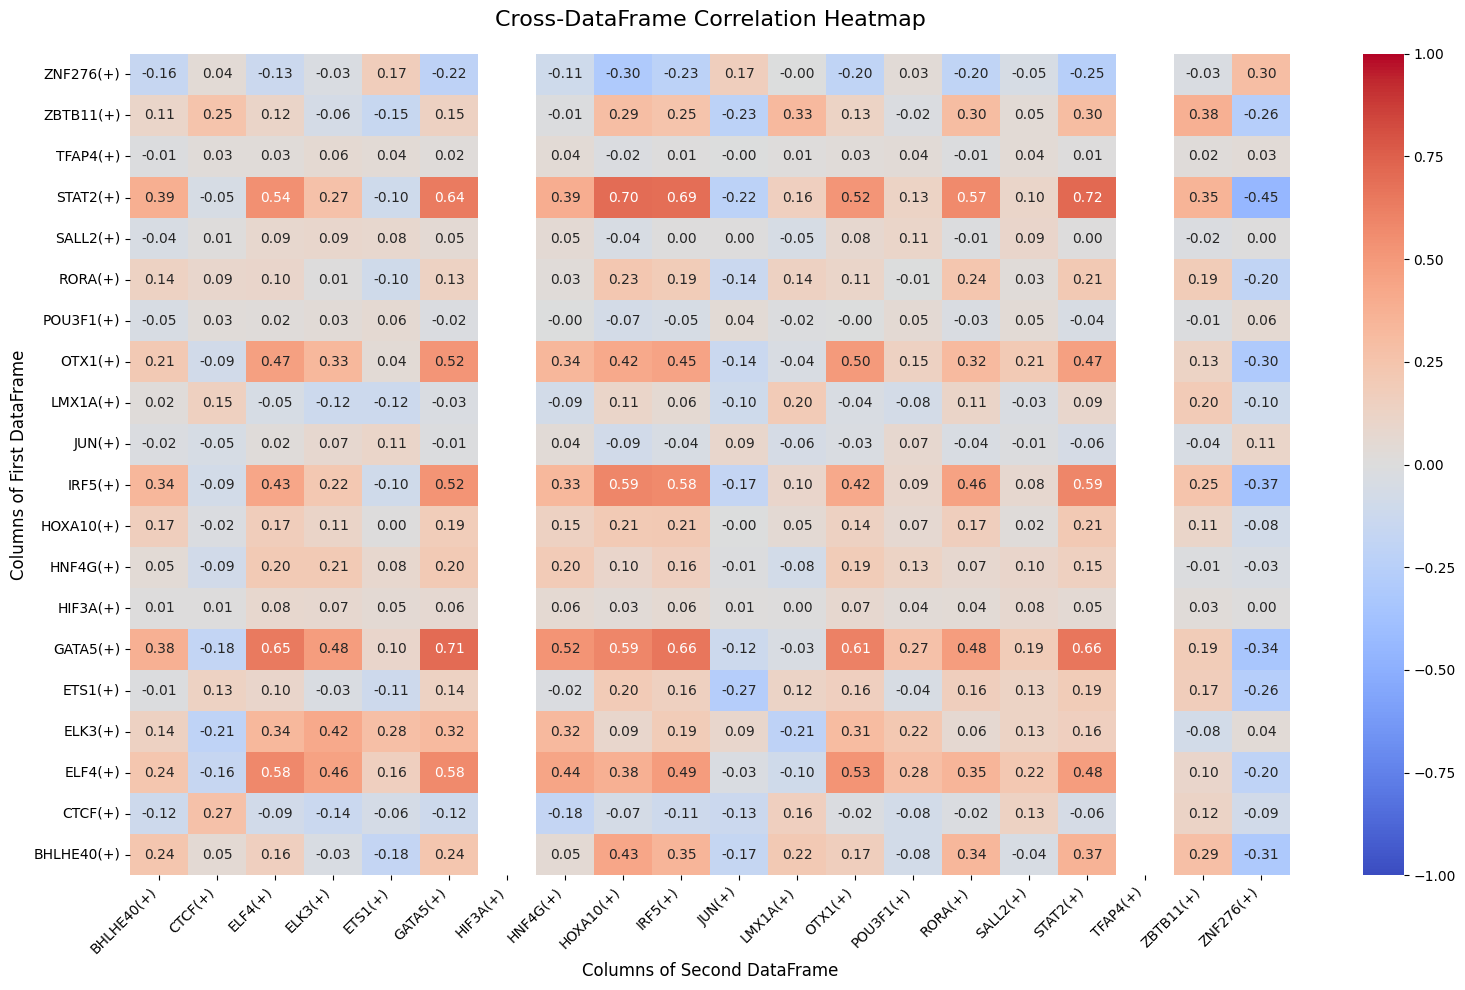

In [99]:
plot_cross_dataframe_correlation_heatmap(correlation_matrix,
                                         df1_cols,
                                         df2_cols,
                                         title='Cross-DataFrame Correlation Heatmap',
                                         vmax=1,
                                         vmin=-1,
                                         center=0)

In [100]:
rmse_matrix = np.zeros((len(df1_cols), len(df2_cols)))

# Calculate correlations
for i, col1 in enumerate(df1_cols):
    for j, col2 in enumerate(df2_cols):
        rmse = np.sqrt(np.mean((auc_mtx_true[col1] - auc_mtx_pred[col2])**2))
        rmse_matrix[i, j] = rmse


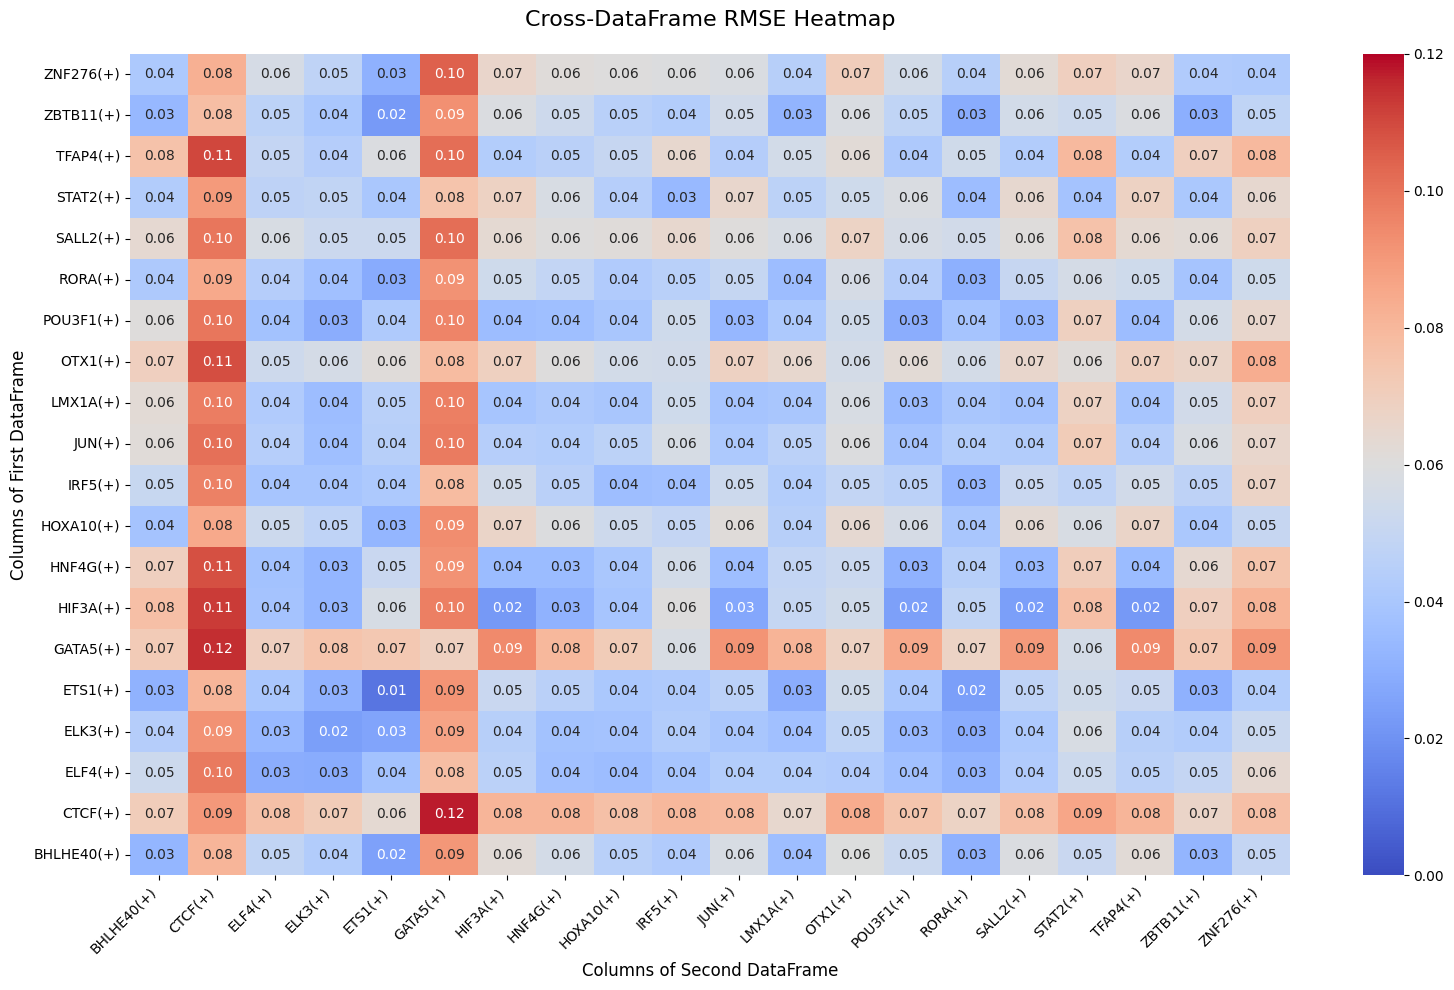

In [101]:
plot_cross_dataframe_correlation_heatmap(rmse_matrix,
                                         df1_cols,
                                         df2_cols,
                                         title='Cross-DataFrame RMSE Heatmap')

scButterfly

In [624]:
os.chdir('/workspace/Benchmarking')
from metrics import run_pyscenic, compute_auc

In [200]:
run_pyscenic('/workspace/Benchmarking/data_scbutterfly/lymphoma_RNA_hv.h5ad', '/workspace/Benchmarking/data_scbutterfly', model='scButterfly')


2025-05-19 15:23:01,642 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 15:23:02,236 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.

2025-05-19 15:27:53,250 - pyscenic.cli.pyscenic - INFO - Writing results to file.


preparing dask client
parsing input
creating dask graph
20 partitions
computing dask graph
not shutting down client, client was created externally
finished



2025-05-19 15:28:03,996 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-05-19 15:28:04,128 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 15:28:04,852 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-05-19 15:28:04,898 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-05-19 15:28:06,506 - pyscenic.utils - INFO - Creating modules.

2025-05-19 15:28:24,480 - pyscenic.cli.pyscenic - IN

In [201]:
auc_mtx2 = compute_auc(input_path ='/workspace/Benchmarking/data_scbutterfly/scButterflydata_scenic.loom', data_dir = '/workspace/Benchmarking/data_scbutterfly', output_file_name = 'lymphoma_auc_true.loom', loom_file_name = '')


2025-05-19 15:29:54,378 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 15:29:55,053 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-05-19 15:29:55,115 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.


Create regulons from a dataframe of enriched features.
Additional columns saved: []



2025-05-19 15:30:02,316 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [202]:
auc_mtx2

,EBF1(+),EGR1(+),FOS(+),GATA5(+),HDX(+),HNF4G(+),IKZF2(+),IRF5(+),JUN(+),LMX1A(+),...,OTX1(+),PAX6(+),POU2F3(+),RFX5(+),RXRA(+),SIX4(+),TBX21(+),TCF7L2(+),ZNF274(+),ZNF695(+)
AAACAGCCAGAACCGA-1,0.136937,0.025294,0.017879,0.149697,0.268333,0.082883,0.118667,0.00000,0.052381,0.000000,...,0.140000,0.080833,0.078485,0.108333,0.019024,0.054444,0.028000,0.022353,0.093333,0.000000
AAACAGCCAGCCTAAC-1,0.045045,0.006275,0.042071,0.145455,0.000000,0.101261,0.271333,0.00000,0.082540,0.000000,...,0.000000,0.003333,0.052121,0.008258,0.000000,0.000000,0.104000,0.042288,0.120000,0.107576
AAACAGCCATATTGAC-1,0.040961,0.052353,0.026010,0.224848,0.000000,0.048108,0.099333,0.00000,0.040000,0.000000,...,0.036190,0.000000,0.019091,0.038788,0.051382,0.000000,0.138667,0.048889,0.140952,0.000000
AAACATGCAAATTCGT-1,0.050631,0.040196,0.018030,0.086061,0.000000,0.037838,0.000000,0.00000,0.003175,0.033333,...,0.068571,0.000000,0.029091,0.042803,0.000000,0.000000,0.044000,0.004248,0.000000,0.027273
AAACATGCAACCTAAT-1,0.071952,0.028627,0.201111,0.438788,0.345000,0.000000,0.021333,0.00000,0.009206,0.000000,...,0.039683,0.000000,0.044545,0.017652,0.150894,0.032222,0.000000,0.181438,0.052381,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTATGGTGC-1,0.028288,0.056275,0.038434,0.000000,0.000000,0.067387,0.000000,0.00000,0.061587,0.000000,...,0.109841,0.000000,0.036364,0.053485,0.000000,0.039630,0.001333,0.048301,0.000000,0.016061
TTTGTTGGTCAATACG-1,0.035676,0.019020,0.015303,0.069091,0.000000,0.040360,0.046667,0.07619,0.034286,0.000000,...,0.035873,0.000000,0.074545,0.045227,0.000000,0.030741,0.000000,0.025098,0.000000,0.000000
TTTGTTGGTCAGGAAG-1,0.013694,0.007647,0.024242,0.087273,0.000000,0.070090,0.000000,0.00000,0.042222,0.000000,...,0.000000,0.009167,0.013939,0.028182,0.041463,0.000000,0.016667,0.024444,0.137143,0.030000
TTTGTTGGTTCAAGAT-1,0.061381,0.006275,0.044242,0.087879,0.000000,0.088649,0.000000,0.00000,0.084127,0.062667,...,0.000000,0.002500,0.011818,0.017121,0.000000,0.000000,0.012000,0.043072,0.000000,0.068788


In [5]:
lf = lp.connect('lymphoma_pyscenic_output.loom', mode='r+', validate=False )
auc_mtx2 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [203]:
auc_mtx2_pred = compute_auc('/workspace/scButterfly/data/lymphoma/predicted/pred_RNA_lymphoma2.h5ad', '/workspace/Benchmarking/data_scbutterfly', 'lymphoma_scenic_pred.loom', 'auc_pred.loom')


2025-05-19 15:32:50,217 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 15:32:50,434 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-05-19 15:32:50,496 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.


Create regulons from a dataframe of enriched features.
Additional columns saved: []


Less than 80% of the genes in HDX(+) are present in the expression matrix.
Less than 80% of the genes in EBF1(+) are present in the expression matrix.
Less than 80% of the genes in FOS(+) are present in the expression matrix.
Less than 80% of the genes in IKZF2(+) are present in the expression matrix.
Less than 80% of the genes in JUN(+) are present in the expression matrix.
Less than 80% of the genes in EGR1(+) are present in the expression matrix.
Less than 80% of the genes in NANOG(+) are present in the expression matrix.
Less than 80% of the genes in LMX1A(+) are present in the expression matrix.
Less than 80% of the genes in PAX6(+) are present in the expression matrix.
Less than 80% of the genes in SIX4(+) are present in the expression matrix.
Less than 80% of the genes in ZNF695(+) are present in the expression matrix.
Less than 80% of the genes in TCF7L2(+) are present in the expression matrix.
Less than 80% of the genes in RXRA(+) are present in the expression matrix.

2025-05

In [434]:
from metrics import compute_grcs

In [205]:
compute_grcs(auc_mtx2, auc_mtx2_pred)

(0.1322558468360226,
 {'GATA5(+)': 0.7085747145744128,
  'HNF4G(+)': 0.23670375623264614,
  'OTX1(+)': 0.7733284362556362,
  'POU2F3(+)': 0.4135591769986755,
  'RFX5(+)': 0.48275963153128865,
  'TBX21(+)': 0.15583301041481204,
  'ZNF274(+)': 0.006614057549003156})

Babel

In [ ]:
run_pyscenic('/workspace/Benchmarking/data_scbutterfly/lymphoma_RNA_hv.h5ad', '/workspace/Benchmarking/data_all', 'babel')


2025-05-19 14:21:09,424 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 14:21:10,034 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.


10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}



2025-05-19 14:26:07,624 - pyscenic.cli.pyscenic - INFO - Writing results to file.


preparing dask client
parsing input
creating dask graph
20 partitions
computing dask graph
not shutting down client, client was created externally
finished



2025-05-19 14:26:18,151 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-05-19 14:26:18,285 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-19 14:26:19,067 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-05-19 14:26:19,112 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-05-19 14:26:20,896 - pyscenic.utils - INFO - Creating modules.

2025-05-19 14:26:38,777 - pyscenic.cli.pyscenic - IN

In [625]:
auc_mtx_babel = compute_auc(input_path ='/workspace/Benchmarking/data_all/babeldata_scenic.loom', data_dir ='/workspace/Benchmarking/data_all', output_file_name ='babel_auc_true.loom', loom_file_name = '')


2025-05-28 12:44:50,006 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-28 12:44:50,587 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-05-28 12:44:50,639 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.


Create regulons from a dataframe of enriched features.
Additional columns saved: []



2025-05-28 12:44:58,192 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [626]:
auc_mtx_babel

,EBF1(+),FOS(+),GATA5(+),HDX(+),HNF4G(+),IKZF2(+),JUN(+),LMX1A(+),NANOG(+),OTX1(+),PAX6(+),RFX5(+),RXRA(+),SIX4(+),TCF7L2(+)
AAACAGCCAGAACCGA-1,0.134188,0.014167,0.041818,0.161667,0.048000,0.047009,0.000000,0.014510,0.046296,0.152424,0.102222,0.080090,0.000000,0.007333,0.027572
AAACAGCCAGCCTAAC-1,0.018034,0.031146,0.169091,0.000000,0.060889,0.039658,0.107407,0.078824,0.061852,0.000000,0.000000,0.042703,0.019770,0.000000,0.035309
AAACAGCCATATTGAC-1,0.017009,0.035937,0.297576,0.000000,0.026778,0.076752,0.000000,0.000000,0.044815,0.016970,0.015556,0.039279,0.021609,0.000000,0.029712
AAACATGCAAATTCGT-1,0.037607,0.031979,0.084848,0.000000,0.056000,0.015897,0.000000,0.000000,0.000000,0.059394,0.005833,0.039640,0.000000,0.000000,0.027037
AAACATGCAACCTAAT-1,0.043248,0.205000,0.489091,0.078333,0.007778,0.023932,0.000000,0.000000,0.062222,0.037273,0.000000,0.018739,0.155402,0.000000,0.142963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTATGGTGC-1,0.074701,0.048021,0.000000,0.000000,0.022111,0.047009,0.000000,0.016078,0.002593,0.094848,0.070556,0.059009,0.042989,0.000000,0.048066
TTTGTTGGTCAATACG-1,0.018718,0.011042,0.018182,0.000000,0.035000,0.009060,0.000000,0.000000,0.000000,0.014545,0.038611,0.041622,0.018391,0.060000,0.013580
TTTGTTGGTCAGGAAG-1,0.019829,0.030104,0.078788,0.000000,0.034556,0.056410,0.000000,0.025882,0.060741,0.000000,0.000000,0.020180,0.021379,0.000000,0.023457
TTTGTTGGTTCAAGAT-1,0.040427,0.039792,0.230909,0.000000,0.043556,0.125299,0.000000,0.023137,0.008889,0.000000,0.000000,0.050090,0.020000,0.000000,0.032675


In [171]:
auc_mtx_babel2 = compute_auc(input_path ='/workspace/Benchmarking/data_babel/babeldata_scenic.loom', data_dir ='/workspace/Benchmarking/data_babel', output_file_name ='babel_auc_true.loom', loom_file_name = '')

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}



2025-05-19 13:52:51,844 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.


10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}



2025-05-19 13:52:52,451 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-05-19 13:52:52,548 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.


Create regulons from a dataframe of enriched features.
Additional columns saved: []
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}



2025-05-19 13:53:01,368 - pyscenic.cli.pyscenic - INFO - Writing results to file.


10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [173]:
compute_grcs(auc_mtx_babel, auc_mtx_babel2)

(0.895018757304322,
 {'BCL6(+)': 0.9451451692064323,
  'BHLHE40(+)': 0.9364770068135255,
  'CTCF(+)': 0.9109620245081066,
  'ELF4(+)': 0.9376958727633816,
  'ETS1(+)': 0.918285016926569,
  'GATA5(+)': 0.9244404994133409,
  'HNF4G(+)': 0.9653615587626415,
  'HOXA10(+)': 0.9352724097777232,
  'IRF5(+)': 0.9581253029725431,
  'JUN(+)': 0.8444977949461621,
  'LMX1A(+)': 0.6517899050077176,
  'MTF1(+)': 0.832450351502196,
  'OTX1(+)': 0.8831008286519216,
  'POU3F1(+)': 0.880576697982756,
  'RFX5(+)': 0.968089610081867,
  'STAT2(+)': 0.9292892330129003,
  'TBX21(+)': 0.9075175419426362,
  'TFAP4(+)': 0.8957764115188676,
  'ZBTB11(+)': 0.9608029717479748,
  'ZNF695(+)': 0.7147189385471765})

In [436]:
def bootstrap_auc(input_file:str, data_dir:str, n_iterations:int = 50, seed:int = 999):
    grcs = np.zeros(n_iterations)
    for i in range(n_iterations):
        auc_mtx = compute_auc(input_path=input_file, data_dir=data_dir, output_file_name='bootstrap_auc.loom', loom_file_name='')
        auc_mtx2 = compute_auc(input_path=input_file, data_dir=data_dir, output_file_name='bootstrap_auc.loom', loom_file_name='')
        grcs[i] = compute_grcs(auc_mtx, auc_mtx2)[0]
    return {'mean': np.mean(grcs), 'std': np.std(grcs)}   

In [ ]:
bootstrap_results_babel = bootstrap_auc('/workspace/Benchmarking/data_all/babeldata_scenic.loom', '/workspace/Benchmarking/data_all', n_iterations=20, seed=999)

In [438]:
bootstrap_results_babel

{'mean': 0.9401860019480722, 'std': 0.014041346379138647}

In [627]:
auc_mtx_babel_pred = compute_auc('/workspace/babel/mymodel/atac_rna_test_preds_pp.h5ad', '/workspace/Benchmarking/data_all', 'babeldata_scenic_pred.loom', 'auc_babel_pred.loom')


2025-05-28 12:47:06,549 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-05-28 12:47:08,800 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-05-28 12:47:08,853 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.


Create regulons from a dataframe of enriched features.
Additional columns saved: []



2025-05-28 12:47:26,168 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/venv/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [628]:
compute_grcs(auc_mtx_babel, auc_mtx_babel_pred)

(0.4543889003564583,
 {'EBF1(+)': 0.6845814491666116,
  'FOS(+)': 0.7702325794193836,
  'GATA5(+)': 0.6497901314353245,
  'HDX(+)': 0.4583874807437916,
  'HNF4G(+)': 0.140060538766989,
  'IKZF2(+)': 0.254176134438065,
  'JUN(+)': 0.29082856947794417,
  'LMX1A(+)': 0.021675952631581133,
  'NANOG(+)': 0.49547859450033893,
  'OTX1(+)': 0.7386703270846021,
  'PAX6(+)': 0.5155501886109075,
  'RFX5(+)': 0.21987520473908528,
  'RXRA(+)': 0.784439150931652,
  'SIX4(+)': -0.0010727837671110085,
  'TCF7L2(+)': 0.793159987167709})

In [ ]:
babel_true = anndata.AnnData(auc_mtx_babel, dtype='float64')
babel_pred = anndata.AnnData(auc_mtx_babel_pred, dtype='float64')
babel_true_test = babel_true[babel_pred.obs_names].copy()
RNA_pred = sc.read_h5ad('/workspace/babel/mymodel/atac_rna_test_preds_pp.h5ad')
babel_pred.obs['Cell Types'] = RNA_pred.obs['Cell Types']
babel_true_test.obs['Cell Types'] = RNA_pred.obs['Cell Types']


In [ ]:
babel_true_test.obs['group'] = babel_true_test.obs['Cell Types'].map(
    lambda x: 'B' if x in ['B'] else ('LYM' if x in ['Tumor B', 'Tumor B cycling'] else None)
)
data_true = babel_true_test[babel_true_test.obs['group'].isin(['B','LYM'])].copy()


babel_pred.obs['group'] = babel_pred.obs['Cell Types'].map(
    lambda x: 'B' if x in ['B'] else ('LYM' if x in ['Tumor B', 'Tumor B cycling'] else None)
)
data_pred = babel_pred[babel_pred.obs['group'].isin(['B','LYM'])].copy()

In [656]:
sc.tl.rank_genes_groups(
    data_true,
    groupby='group',
    groups=['LYM'],
    reference='B',
    method='wilcoxon',
    pts=True
)

sc.tl.rank_genes_groups(
    data_pred,
    groupby='group',
    groups=['LYM'],
    reference='B',
    method='wilcoxon',
    pts=True
)

In [657]:
de_true = sc.get.rank_genes_groups_df(data_true, group='LYM')
de_true['neg_log10_padj'] = -np.log10(de_true['pvals_adj'].replace(0, np.nan))

de_pred = sc.get.rank_genes_groups_df(data_pred, group='LYM')
de_pred['neg_log10_padj'] = -np.log10(de_pred['pvals_adj'].replace(0, np.nan))

In [658]:
de_true

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,neg_log10_padj
0,OTX1(+),11.246109,1.304205,2.420361e-29,3.630541e-28,0.988532,27.440029
1,HNF4G(+),6.835024,0.522189,8.199133e-12,4.099567e-11,1.000000,10.387262
2,HDX(+),6.518437,2.085577,7.104386e-11,2.664145e-10,0.672018,9.574442
3,EBF1(+),5.374937,0.335219,7.660973e-08,1.915243e-07,0.997706,6.717776
4,RFX5(+),4.341515,0.212810,1.415037e-05,2.653194e-05,1.000000,4.576231
5,SIX4(+),1.838759,1.005418,6.595060e-02,8.243825e-02,0.268349,1.083871
6,NANOG(+),0.109639,0.407345,9.126959e-01,9.778885e-01,0.456422,0.009711
7,GATA5(+),-0.002642,0.028656,9.978921e-01,9.978921e-01,0.750000,0.000916
8,LMX1A(+),-0.381314,-0.070685,7.029706e-01,8.111199e-01,0.655963,0.090915
9,PAX6(+),-2.382990,-0.190174,1.717267e-02,2.341728e-02,0.972477,1.630464


In [659]:
de_pred

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,neg_log10_padj
0,HDX(+),11.945331,3.421464,6.867684e-33,5.150763e-32,0.942661,31.288128
1,OTX1(+),2.844001,0.112250,4.455098e-03,5.568872e-03,0.993119,2.254233
2,SIX4(+),0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,-0.000000
3,LMX1A(+),-0.703625,-2.088300,4.816664e-01,5.160712e-01,0.004587,0.287290
4,NANOG(+),-1.946196,-2.893562,5.163116e-02,5.957441e-02,0.041284,1.224940
5,HNF4G(+),-3.912647,-0.281946,9.128985e-05,1.244862e-04,1.000000,3.904879
6,EBF1(+),-6.425090,-0.356604,1.317917e-10,1.976875e-10,1.000000,9.704021
7,GATA5(+),-7.181112,-1.455510,6.914655e-13,1.152442e-12,0.596330,11.938381
8,PAX6(+),-7.490214,-0.511872,6.876139e-14,1.289276e-13,0.988532,12.889654
9,RFX5(+),-7.957829,-0.455948,1.750833e-15,3.751786e-15,1.000000,14.425762


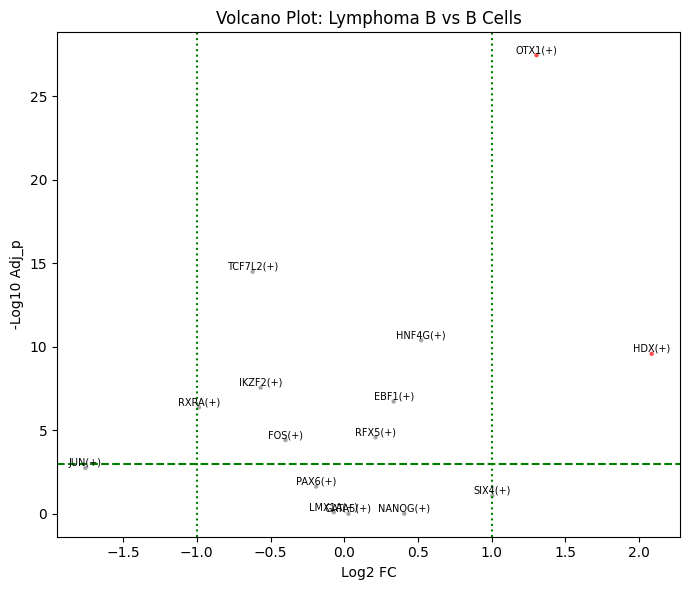

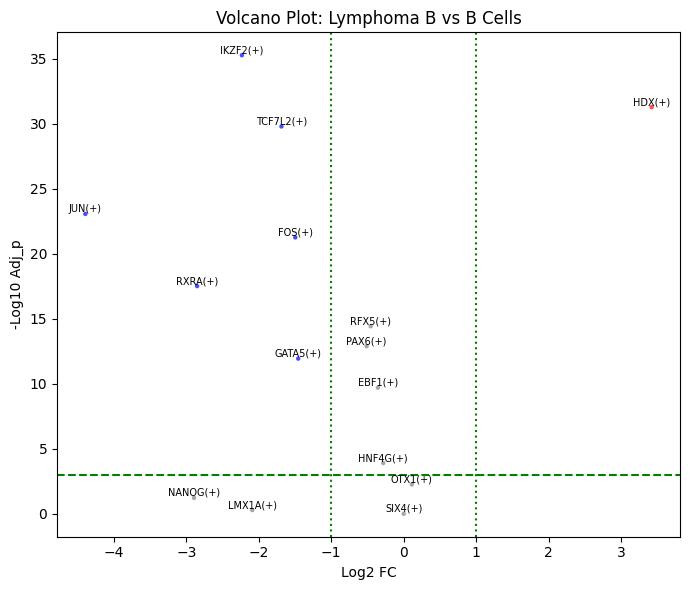

In [662]:
de_true['color'] = 'grey'
de_true.loc[(de_true['logfoldchanges'] > 1) & (de_true['pvals_adj'] < 0.001), 'color'] = 'red'
de_true.loc[(de_true['logfoldchanges'] < -1) & (de_true['pvals_adj'] < 0.001), 'color'] = 'blue'

plt.figure(figsize=(7, 6))
plt.scatter(de_true['logfoldchanges'], de_true['neg_log10_padj'], s=10, alpha=0.7, c=de_true['color'], edgecolor='none')
plt.axhline(-np.log10(0.001), color='green', linestyle='--')
plt.axvline(1, color='green', linestyle='dotted')
plt.axvline(-1, color='green', linestyle='dotted')

# sig_df = df[df['pvals_adj'] < 0.001]
# top_up = sig_df.sort_values(by='logfoldchanges', ascending=False).head(10)
# top_down = sig_df.sort_values(by='logfoldchanges', ascending=True).head(10)

for _, row in de_true.iterrows():
    plt.text(row['logfoldchanges'], row['neg_log10_padj'],
             row['names'], fontsize=7, ha='center', va='bottom', color='black')


plt.xlabel('Log2 FC')
plt.ylabel('-Log10 Adj_p')
plt.title('Volcano Plot: Lymphoma B vs B Cells')
plt.tight_layout()
plt.show()

de_pred['color'] = 'grey'
de_pred.loc[(de_pred['logfoldchanges'] > 1) & (de_pred['pvals_adj'] < 0.001), 'color'] = 'red'
de_pred.loc[(de_pred['logfoldchanges'] < -1) & (de_pred['pvals_adj'] < 0.001), 'color'] = 'blue'

plt.figure(figsize=(7, 6))
plt.scatter(de_pred['logfoldchanges'], de_pred['neg_log10_padj'], s=10, alpha=0.7, c=de_pred['color'], edgecolor='none')
plt.axhline(-np.log10(0.001), color='green', linestyle='--')
plt.axvline(1, color='green', linestyle='dotted')
plt.axvline(-1, color='green', linestyle='dotted')

# sig_df = df[df['pvals_adj'] < 0.001]
# top_up = sig_df.sort_values(by='logfoldchanges', ascending=False).head(10)
# top_down = sig_df.sort_values(by='logfoldchanges', ascending=True).head(10)

for _, row in de_pred.iterrows():
    plt.text(row['logfoldchanges'], row['neg_log10_padj'],
             row['names'], fontsize=7, ha='center', va='bottom', color='black')


plt.xlabel('Log2 FC')
plt.ylabel('-Log10 Adj_p')
plt.title('Volcano Plot: Lymphoma B vs B Cells')
plt.tight_layout()
plt.show()